In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-dark')

In [29]:
import pandas as pd
from numpy import NaN

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import QuantileTransformer, StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import metrics

In [30]:
data = pd.read_csv('hail-2015.csv', index_col = 'X.ZTIME', nrows = 1000000)
data.head()

,LON,LAT,WSR_ID,CELL_ID,RANGE,AZIMUTH,SEVPROB,PROB,MAXSIZE
X.ZTIME,,,,,,,,,
2.015010e+13,-97.16003,32.66308,KDFW,C0,27,207,0,10,0.5
2.015010e+13,-97.01849,32.57796,KDAL,E0,21,187,0,50,0.5
2.015010e+13,-97.01735,32.58810,KDFW,J0,29,190,0,20,0.5
2.015010e+13,-96.99553,32.59287,KDAL,E0,20,184,0,40,0.5
2.015010e+13,-96.96180,32.62550,KDAL,E0,18,179,0,30,0.5


In [31]:
data.shape

(1000000, 9)

In [32]:
data.index = pd.to_datetime(pd.Series(range(len(data))), unit = 's') - pd.to_datetime('1970-01-01')
data.head()

,LON,LAT,WSR_ID,CELL_ID,RANGE,AZIMUTH,SEVPROB,PROB,MAXSIZE
0 days 00:00:00,-97.16003,32.66308,KDFW,C0,27,207,0,10,0.5
0 days 00:00:01,-97.01849,32.57796,KDAL,E0,21,187,0,50,0.5
0 days 00:00:02,-97.01735,32.58810,KDFW,J0,29,190,0,20,0.5
0 days 00:00:03,-96.99553,32.59287,KDAL,E0,20,184,0,40,0.5
0 days 00:00:04,-96.96180,32.62550,KDAL,E0,18,179,0,30,0.5


In [33]:
data.tail()

,LON,LAT,WSR_ID,CELL_ID,RANGE,AZIMUTH,SEVPROB,PROB,MAXSIZE
11 days 13:46:35,-86.60700,28.70398,KEVX,R3,117,198,0,60,0.5
11 days 13:46:36,-85.29064,28.62002,KEVX,U3,121,164,0,90,0.5
11 days 13:46:37,-87.48237,27.83189,KLIX,L5,194,140,-999,-999,-999.0
11 days 13:46:38,-87.50486,28.59768,KLIX,M5,160,130,-999,-999,-999.0
11 days 13:46:39,-88.71541,28.48809,KLIX,N5,125,152,-999,-999,-999.0


#### filling missing values

In [34]:
(data == -999).mean()

LON        0.00000
LAT        0.00000
WSR_ID     0.00000
CELL_ID    0.00000
RANGE      0.00000
AZIMUTH    0.00000
SEVPROB    0.29069
PROB       0.29069
MAXSIZE    0.29069
dtype: float64

In [35]:
data[data.columns[-3:]] = data[data.columns[-3:]].replace({-999 : NaN})
data.isnull().sum()

LON             0
LAT             0
WSR_ID          0
CELL_ID         0
RANGE           0
AZIMUTH         0
SEVPROB    290690
PROB       290690
MAXSIZE    290690
dtype: int64

In [36]:
'''
we have 29% missing values. That's not negligible.
we'll use a filler method that's baced on the last
non missing value, because our data is a time series.

The method we use fills a consecutive range of entries with missing values in the data
in a linear incremental fassion; from the last real value to the closest to come.
'''

data.interpolate(method = 'time', inplace = True)
data.isnull().sum().sum()

0

#### some more preprocessing

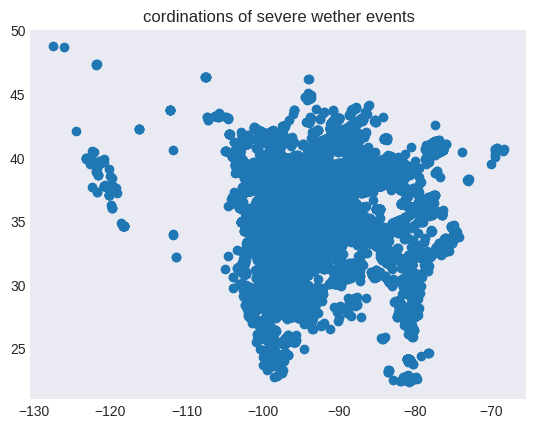

In [37]:
severe_data = data[data['SEVPROB'] >= 80]

plt.scatter(severe_data['LON'], severe_data['LAT'])
plt.title('cordinations of severe wether events')
plt.show()

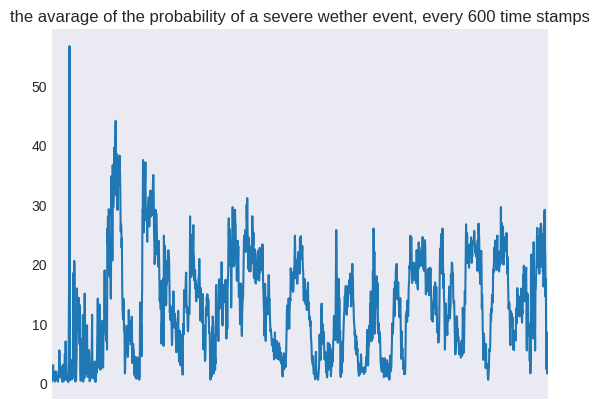

In [38]:
''' 
looks like most severe wether events occurre close to the south or east cost
and a bit around the louisiana
'''

data['SEVPROB'].resample('10T').mean().plot()
plt.title('the avarage of the probability of a severe wether event, every 600 time stamps')
plt.xticks([])
plt.show()

looks periodic

In [39]:
''' avraging over every 60 time stamps '''

data = data.resample('T').mean(numeric_only = True)
data.head()

,LON,LAT,RANGE,AZIMUTH,SEVPROB,PROB,MAXSIZE
0 days 00:00:00,-98.418219,31.068868,48.216667,196.633333,0.166667,41.333333,0.5
0 days 00:01:00,-96.961912,32.544097,28.466667,172.550000,0.583333,34.250000,0.5
0 days 00:02:00,-96.886162,32.836266,17.416667,173.150000,0.500000,26.833333,0.5
0 days 00:03:00,-97.020589,32.899137,21.250000,215.716667,0.000000,26.833333,0.5
0 days 00:04:00,-97.023409,33.054803,15.333333,219.350000,0.000000,23.333333,0.5


In [13]:
''' we are interested in predicting the probabilty of a severe wether event '''

data, target = data.drop('SEVPROB', axis = 1), data['SEVPROB']

data.shape, target.shape

((16667, 6), (16667,))

In [14]:
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = 0.15, random_state = 3)

train_data.shape, test_data.shape, train_target.shape, test_target.shape

((14166, 6), (2501, 6), (14166,), (2501,))

#### Applying the ML models

In [15]:
# for the metric sensetive models we use the more rubost: Quntile Scaler


knn_pipe = Pipeline([('scale', QuantileTransformer()),
                     ('model', KNeighborsRegressor())])

knn = GridSearchCV(estimator = knn_pipe, cv = 3, param_grid = {'model__n_jobs' : [5, 7, 9], 'model__p' : [1, 2]})


svm = Pipeline([('scale', StandardScaler()),
                ('model', SVR())])


forest_pipe = Pipeline([('scale', QuantileTransformer()),
                        ('mpdel', RandomForestRegressor())])

random_forest = GridSearchCV(estimator = forest_pipe, cv = 3, param_grid = {'mpdel__max_features': [3, 4, 5],
                                                                            'mpdel__n_estimators' : [100, 150, 200],
                                                                            'mpdel__min_samples_leaf' : [30, 50]})


gradient_boost = xg.XGBRegressor(n_estimators = 100)


# model evaluation
def print_metric(pred): print(f'MSE: {metrics.mean_absolute_error(test_target, pred)}\nR2: {metrics.r2_score(test_target, pred)}')

In [16]:
knn.fit(train_data, train_target)
print_metric(knn.predict(test_data))

MSE: 2.1305334172253647
R2: 0.905682418570961


In [17]:
svm.fit(train_data, train_target)
print_metric(svm.predict(test_data))

MSE: 1.961094585121024
R2: 0.9181117752094089


In [18]:
random_forest.fit(train_data, train_target)
print_metric(random_forest.predict(test_data))

MSE: 1.9917416934673144
R2: 0.9185248253451793


In [19]:
gradient_boost.fit(train_data, train_target)
print_metric(gradient_boost.predict(test_data))

MSE: 1.928129768648288
R2: 0.9274800468891166


#### harder challange: anticipate the future

In [20]:
def stack_time_series(before: int, after: int):

    ''' reshaping the data so that the challange is: given 'before' minutes of record predict the next 'after' '''

    stacked_target = pd.DataFrame( zip( * (list(target)[before + i:] for i in range(after))) )
    
    stacked_data = { col : pd.DataFrame( zip( * (list(data[col])[i:] for i in range(before))) )  for col in data.columns }

    return pd.concat(stacked_data, axis = 1)[:-after], stacked_target

In [21]:
data, target = stack_time_series(3, 1)
data.head()

LON                              LAT                        \
           0          1          2          0          1          2   
0 -98.418219 -96.961912 -96.886162  31.068868  32.544097  32.836266   
1 -96.961912 -96.886162 -97.020589  32.544097  32.836266  32.899137   
2 -96.886162 -97.020589 -97.023409  32.836266  32.899137  33.054803   
3 -97.020589 -97.023409 -96.474173  32.899137  33.054803  32.766937   
4 -97.023409 -96.474173 -94.576301  33.054803  32.766937  32.490277   

       RANGE                           AZIMUTH                          \
           0          1          2           0           1           2   
0  48.216667  28.466667  17.416667  196.633333  172.550000  173.150000   
1  28.466667  17.416667  21.250000  172.550000  173.150000  215.716667   
2  17.416667  21.250000  15.333333  173.150000  215.716667  219.350000   
3  21.250000  15.333333  33.016667  215.716667  219.350000  201.500000   
4  15.333333  33.016667  82.750000  219.350000  201.500000  166.366667   

        PROB                       MAXSIZE            
           0          1          2       0    1    2  
0  41.333333  34.250000  26.833333     0.5  0.5  0.5  
1  34.250000  26.833333  26.833333     0.5  0.5  0.5  
2  26.833333  26.833333  23.333333     0.5  0.5  0.5  
3  26.833333  23.333333  36.000000     0.5  0.5  0.5  
4  23.333333  36.000000  37.750000     0.5  0.5  0.5

In [22]:
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = 0.15, random_state = 3)
train_data.shape, test_data.shape, train_target.shape, test_target.shape

((14164, 18), (2500, 18), (14164, 1), (2500, 1))

In [23]:
knn.fit(train_data, train_target)
print_metric(knn.predict(test_data))

MSE: 4.042405560080031
R2: 0.6633508301658111


In [24]:
gradient_boost.fit(train_data, train_target)
print_metric(gradient_boost.predict(test_data))

MSE: 4.151976891907229
R2: 0.6542353322439022


In [25]:
svm.fit(train_data, train_target[0])
print_metric(svm.predict(test_data))

MSE: 4.04611388832779
R2: 0.6549217894274115


In [26]:
random_forest.fit(train_data, train_target[0])
print_metric(random_forest.predict(test_data))

MSE: 4.057632186491415
R2: 0.6710732582773035
